(examples/pyquil_demo)=
# Zero Noise Extrapolation with pyQuil and parametric compilation
In this example we demonstrate how to use Zero Noise Extrapolation (ZNE) in Mitiq with a parametrically compiled program in pyQuil. Parametric compilation saves time by compiling the program ansatz once, instead of compiling each time the parameters are updated. In pyQuil, a `memory_map` argument is used to substitute in values for previously-declared Quil variables in the pre-compiled executable. 

When adding the noise mitigation function `zne.execute_with_zne` the `memory_map` is still passed to the executor function and the circuit parameters are updated without the need for repeated compilation. 

The example shown here is adapted from the [pyQuil parametric compilation tutorial](https://pyquil-docs.rigetti.com/en/v2.28.1/migration3-declare.html).

In [1]:
import numpy as np
from pyquil import get_qc, Program
from pyquil.gates import RX, RY, H, CNOT, MEASURE
import mitiq
from mitiq import zne
from scipy import optimize

Use the get_qc command to initialize the simulated noisy device where the PyQuil program will run.

In [2]:
# initialize the quantum device
qc = get_qc("2q-noisy-qvm")

Set up the quantum circuit

In [3]:
program = Program()
theta = program.declare("theta", memory_type="REAL")
ro = program.declare("ro", memory_type="BIT", memory_size=1)
program += RX(theta, 0)
program += RY(theta, 0) 
program += RX(theta, 1)
program += RY(theta, 1)
program += H(0)
program += CNOT(1,0)
program += H(0)
program += MEASURE(0, ro[0])

Mitiq's `zne.execute_with_zne` function takes a quantum program (e.g. PyQuil program) 
and an executor function as arguments. The executor function must output the expectation value
resulting from running the quantum program.

In [4]:
def expectation(theta, executable: Program) -> float:
    bitstrings = qc.run(
        executable.write_memory(region_name="theta", value=theta)
    ).readout_data.get("ro")
    result = np.mean(bitstrings[:, 0])
    return result

Run the parameter scan without noise mitigation

In [5]:
program.wrap_in_numshots_loop(1000)
quil_prog = qc.compiler.quil_to_native_quil(program, protoquil=True)

thetas = np.linspace(0, 2 * np.pi, 21)
results = []
for theta in thetas:
    results.append(expectation(theta, quil_prog))

Plot the energy landscape without noise mitigation

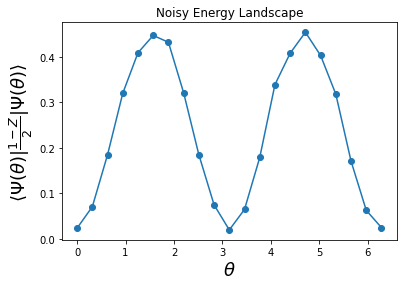

In [6]:
from matplotlib import pyplot as plt
_ = plt.figure(1)
_ = plt.plot(thetas, results, 'o-')
_ = plt.xlabel(r'$\theta$', fontsize=18)
_ = plt.ylabel(r'$\langle \Psi(\theta) | \frac{1 - Z}{2} | \Psi(\theta) \rangle$', fontsize=18)    
_ = plt.title('Noisy Energy Landscape')
plt.show()

Run optimization without noise mitigation

In [7]:
quil_prog = qc.compiler.quil_to_native_quil(program, protoquil=True)
init_angle = [0.1]
res = optimize.minimize(expectation, init_angle, args=(quil_prog), method='COBYLA')
print(res)

     fun: 0.021
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 20
  status: 1
 success: True
       x: array([-0.08955312])


Now run parameter scan with ZNE

In [8]:
quil_prog = qc.compiler.quil_to_native_quil(program, protoquil=True)
init_angle = [0.1]
results_zne = []
# here we use a linear fit for the zero noise extrapolation
fac = mitiq.zne.inference.LinearFactory(scale_factors=[1.0, 3.0])
for theta in thetas:
    results_zne.append(
        zne.execute_with_zne(quil_prog, lambda p: expectation(theta, p), factory=fac)
    )

Plot the energy landscape with ZNE

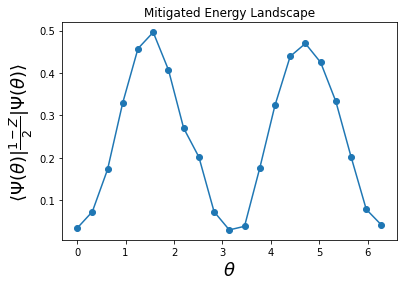

In [9]:
_ = plt.figure(2)
_ = plt.plot(thetas, results_zne, 'o-')
_ = plt.xlabel(r'$\theta$', fontsize=18)
_ = plt.ylabel(r'$\langle \Psi(\theta) | \frac{1 - Z}{2} | \Psi(\theta) \rangle$', fontsize=18)    
_ = plt.title('Mitigated Energy Landscape')
plt.show()

Run optimization with ZNE

In [10]:
def mitigated_expectation(thetas, executable: Program, factory) -> float:
    mitigated_exp =  zne.execute_with_zne(quil_prog, lambda p: expectation(thetas, p), factory=factory)
    return mitigated_exp

quil_prog = qc.compiler.quil_to_native_quil(program, protoquil=True)
res_zne = optimize.minimize(mitigated_expectation, init_angle, args=(quil_prog, fac), method='COBYLA')
print(res_zne)

     fun: 0.016000000000000007
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 20
  status: 1
 success: True
       x: array([-0.04267812])


## References
[1] [Parametric compilation tutorial in pyQuil.](https://pyquil-docs.rigetti.com/en/v2.28.1/migration3-declare.html)

display information about Mitiq, packages, and Python version/platform

In [12]:
mitiq.about()


Mitiq: A Python toolkit for implementing error mitigation on quantum computers
Authored by: Mitiq team, 2020 & later (https://github.com/unitaryfund/mitiq)

Mitiq Version:	0.13.0dev

Core Dependencies
-----------------
Cirq Version:	0.13.1
NumPy Version:	1.20.3
SciPy Version:	1.7.3

Optional Dependencies
---------------------
PyQuil Version:	3.0.1
Qiskit Version:	0.32.1
Braket Version:	1.14.0

Python Version:	3.7.7
Platform Info:	Linux (x86_64)
